In [155]:
# import packages
# matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pathlib import Path
import time
import os


In [156]:
dataset = pd.read_csv( index_col = 0,  parse_dates = True, infer_datetime_format = True, 
                         filepath_or_buffer = './data/2018-01-01__2019-01-01__SConservatory__allMerged.csv')

In [157]:
dataset.index = pd.to_datetime(dataset.index, utc=True).tz_convert('America/Los_Angeles')

In [158]:
orderedSensorList = ( 'co2_1','co2_2', 'co2_3', 'co2_4',                        
                      'temp_1', 'temp_2', 'temp_3', 'temp_4',                     
                      'dew_1','dew_2', 'dew_3', 'dew_4',
                      'relH_1', 'relH_2', 'relH_3', 'relH_4',
                      'externTemp_1', 
                      'externHumid_1', 
                      'externSunrise_1',                      
                      'externCondition_1',
                    )  

In [159]:
orderedDataset  = dataset.reindex(index = dataset.index, columns = orderedSensorList)

In [160]:
dayIndexDF = pd.Series(index = orderedDataset.index, 
                       data = np.round(orderedDataset.index.dayofweek/6, decimals=2), 
                       name='dayIndex')
hourIndexDF = pd.Series(index = orderedDataset.index, 
                       data = np.round(orderedDataset.index.hour/24, decimals=2), 
                       name='hourIndex')

In [161]:
orderedDatasetTimeReference = pd.concat([orderedDataset, hourIndexDF, dayIndexDF], axis=1)

In [162]:
saturdayVal = np.round(5/6,decimals=2)
sundayVal = np.round(6/6,decimals=2)
weekdayData = orderedDatasetTimeReference[ ( dayIndexDF != saturdayVal) &( dayIndexDF != sundayVal) ]
weekendData = orderedDatasetTimeReference[ ( dayIndexDF == saturdayVal) | (dayIndexDF == sundayVal) ]

In [163]:
continuousData = weekdayData.values[:, 0:17]
categoricalData = weekdayData.values[:, 17:]

standardScaler = StandardScaler()
standardScaler.fit(continuousData)

minMaxScaler = MinMaxScaler()
minMaxScaler.fit(categoricalData)

scaledContinuousData = standardScaler.transform(continuousData)
scaledCategoricalData = minMaxScaler.transform(categoricalData)

weekdayData_scaled =  pd.DataFrame(index = weekdayData.index,
                                   data = np.hstack( (scaledContinuousData, scaledCategoricalData)),
                                   columns = weekdayData.columns)

In [167]:
del weekdayData_scaled['externSunrise_1']

In [168]:
weekdayData_scaled.shape

(25033, 21)

In [169]:
nb_epoch = 300
batch_size = 128
input_dim = weekdayData_scaled.shape[1] #num of columns, 30
encoding_dim = 14
hidden_dim = int(encoding_dim / 2) #i.e. 10
#hidden_dim_2 = int(hidden_dim / 2) #i.e. 5
learning_rate = 1e-8

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
#encoder = Dense(hidden_dim_2, activation="tanh")(encoder)
#decoder = Dense(hidden_dim_2, activation='relu')(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [170]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_plants.h5",
                               save_best_only=True,
                               verbose=0)



In [171]:
tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

In [172]:
#set random seed and percentage of test data
RANDOM_SEED = 314 #used to help randomly select the data points
TEST_PCT = 0.2 # 20% of the data

In [173]:
train_x, test_x = train_test_split(weekdayData_scaled, test_size=TEST_PCT, random_state=RANDOM_SEED)

In [175]:
history = autoencoder.fit(train_x, train_x,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test_x, test_x),
                    verbose=1,
                    callbacks=[cp, tb]).history

Train on 20026 samples, validate on 5007 samples
Epoch 1/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4097 - acc: 0.6092 - val_loss: 0.4040 - val_acc: 0.6209
Epoch 2/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4096 - acc: 0.6096 - val_loss: 0.4040 - val_acc: 0.6213
Epoch 3/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4097 - acc: 0.6101 - val_loss: 0.4040 - val_acc: 0.6203
Epoch 4/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4096 - acc: 0.6119 - val_loss: 0.4040 - val_acc: 0.6193
Epoch 5/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4096 - acc: 0.6115 - val_loss: 0.4040 - val_acc: 0.6121
Epoch 6/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4096 - acc: 0.6101 - val_loss: 0.4040 - val_acc: 0.6243
Epoch 7/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4096 - acc: 0.6114 - val_loss: 0.4039 - v

20026/20026 [==============================] - 1s 33us/step - loss: 0.4093 - acc: 0.6328 - val_loss: 0.4036 - val_acc: 0.6335
Epoch 60/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4093 - acc: 0.6336 - val_loss: 0.4036 - val_acc: 0.6371
Epoch 61/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4093 - acc: 0.6318 - val_loss: 0.4038 - val_acc: 0.6335
Epoch 62/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4093 - acc: 0.6315 - val_loss: 0.4037 - val_acc: 0.6413
Epoch 63/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4093 - acc: 0.6337 - val_loss: 0.4036 - val_acc: 0.6387
Epoch 64/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4093 - acc: 0.6327 - val_loss: 0.4036 - val_acc: 0.6349
Epoch 65/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4093 - acc: 0.6312 - val_loss: 0.4037 - val_acc: 0.6257
Epoch 66/300
20026/20026 [==============

Epoch 118/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4091 - acc: 0.6373 - val_loss: 0.4037 - val_acc: 0.6379
Epoch 119/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4091 - acc: 0.6359 - val_loss: 0.4038 - val_acc: 0.6363
Epoch 120/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4091 - acc: 0.6367 - val_loss: 0.4036 - val_acc: 0.6405
Epoch 121/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4091 - acc: 0.6357 - val_loss: 0.4036 - val_acc: 0.6419
Epoch 122/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4091 - acc: 0.6350 - val_loss: 0.4036 - val_acc: 0.6397
Epoch 123/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4091 - acc: 0.6379 - val_loss: 0.4036 - val_acc: 0.6415
Epoch 124/300
20026/20026 [==============================] - 1s 32us/step - loss: 0.4091 - acc: 0.6377 - val_loss: 0.4036 - val_acc: 0.6335
Epoch 125/300
20026/

20026/20026 [==============================] - 1s 33us/step - loss: 0.4090 - acc: 0.6355 - val_loss: 0.4035 - val_acc: 0.6341
Epoch 177/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4090 - acc: 0.6376 - val_loss: 0.4035 - val_acc: 0.6375
Epoch 178/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4090 - acc: 0.6378 - val_loss: 0.4034 - val_acc: 0.6417
Epoch 179/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4090 - acc: 0.6362 - val_loss: 0.4034 - val_acc: 0.6381
Epoch 180/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4090 - acc: 0.6378 - val_loss: 0.4034 - val_acc: 0.6373
Epoch 181/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4090 - acc: 0.6370 - val_loss: 0.4034 - val_acc: 0.6405
Epoch 182/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4089 - acc: 0.6358 - val_loss: 0.4035 - val_acc: 0.6317
Epoch 183/300
20026/20026 [=======

20026/20026 [==============================] - 1s 33us/step - loss: 0.4089 - acc: 0.6368 - val_loss: 0.4032 - val_acc: 0.6357
Epoch 235/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4089 - acc: 0.6372 - val_loss: 0.4032 - val_acc: 0.6397
Epoch 236/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4089 - acc: 0.6389 - val_loss: 0.4032 - val_acc: 0.6349
Epoch 237/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4089 - acc: 0.6360 - val_loss: 0.4032 - val_acc: 0.6353
Epoch 238/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4089 - acc: 0.6370 - val_loss: 0.4032 - val_acc: 0.6439
Epoch 239/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4089 - acc: 0.6363 - val_loss: 0.4032 - val_acc: 0.6395
Epoch 240/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4088 - acc: 0.6374 - val_loss: 0.4032 - val_acc: 0.6385
Epoch 241/300
20026/20026 [=======

20026/20026 [==============================] - 1s 33us/step - loss: 0.4088 - acc: 0.6377 - val_loss: 0.4031 - val_acc: 0.6429
Epoch 293/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4088 - acc: 0.6372 - val_loss: 0.4030 - val_acc: 0.6371
Epoch 294/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4088 - acc: 0.6375 - val_loss: 0.4030 - val_acc: 0.6371
Epoch 295/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4088 - acc: 0.6361 - val_loss: 0.4031 - val_acc: 0.6379
Epoch 296/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4088 - acc: 0.6377 - val_loss: 0.4031 - val_acc: 0.6407
Epoch 297/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4088 - acc: 0.6373 - val_loss: 0.4031 - val_acc: 0.6403
Epoch 298/300
20026/20026 [==============================] - 1s 33us/step - loss: 0.4088 - acc: 0.6384 - val_loss: 0.4031 - val_acc: 0.6343
Epoch 299/300
20026/20026 [=======

In [176]:
weekdayData_predictions = autoencoder.predict(weekdayData_scaled)

In [177]:
mse_whole_year = np.mean(np.power(weekdayData_scaled - weekdayData_predictions, 2), axis=1)

In [178]:
mse_whole_year.mean()+3*mse_whole_year.std()


2.570112637244135

In [192]:
np.argwhere(mse_whole_year>=(mse_whole_year.mean()+1.5*mse_whole_year.std()))

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


array([[  325],
       [  326],
       [  327],
       [  328],
       [ 7799],
       [21492],
       [21493]])

In [180]:
whole_year_df = pd.DataFrame(weekdayData_scaled,columns=weekdayData_scaled.columns)

In [194]:
whole_year_df['anomaly'] = pd.Series((mse_whole_year>(mse_whole_year.mean()+1.5*mse_whole_year.std())).astype(int), index=whole_year_df.index)

In [195]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = [9.5, 13]
plt.rcParams['figure.subplot.left'] = plt.rcParams['figure.subplot.bottom'] = .1
plt.rcParams['figure.subplot.right'] = plt.rcParams['figure.subplot.top'] = .9

<IPython.core.display.Javascript object>


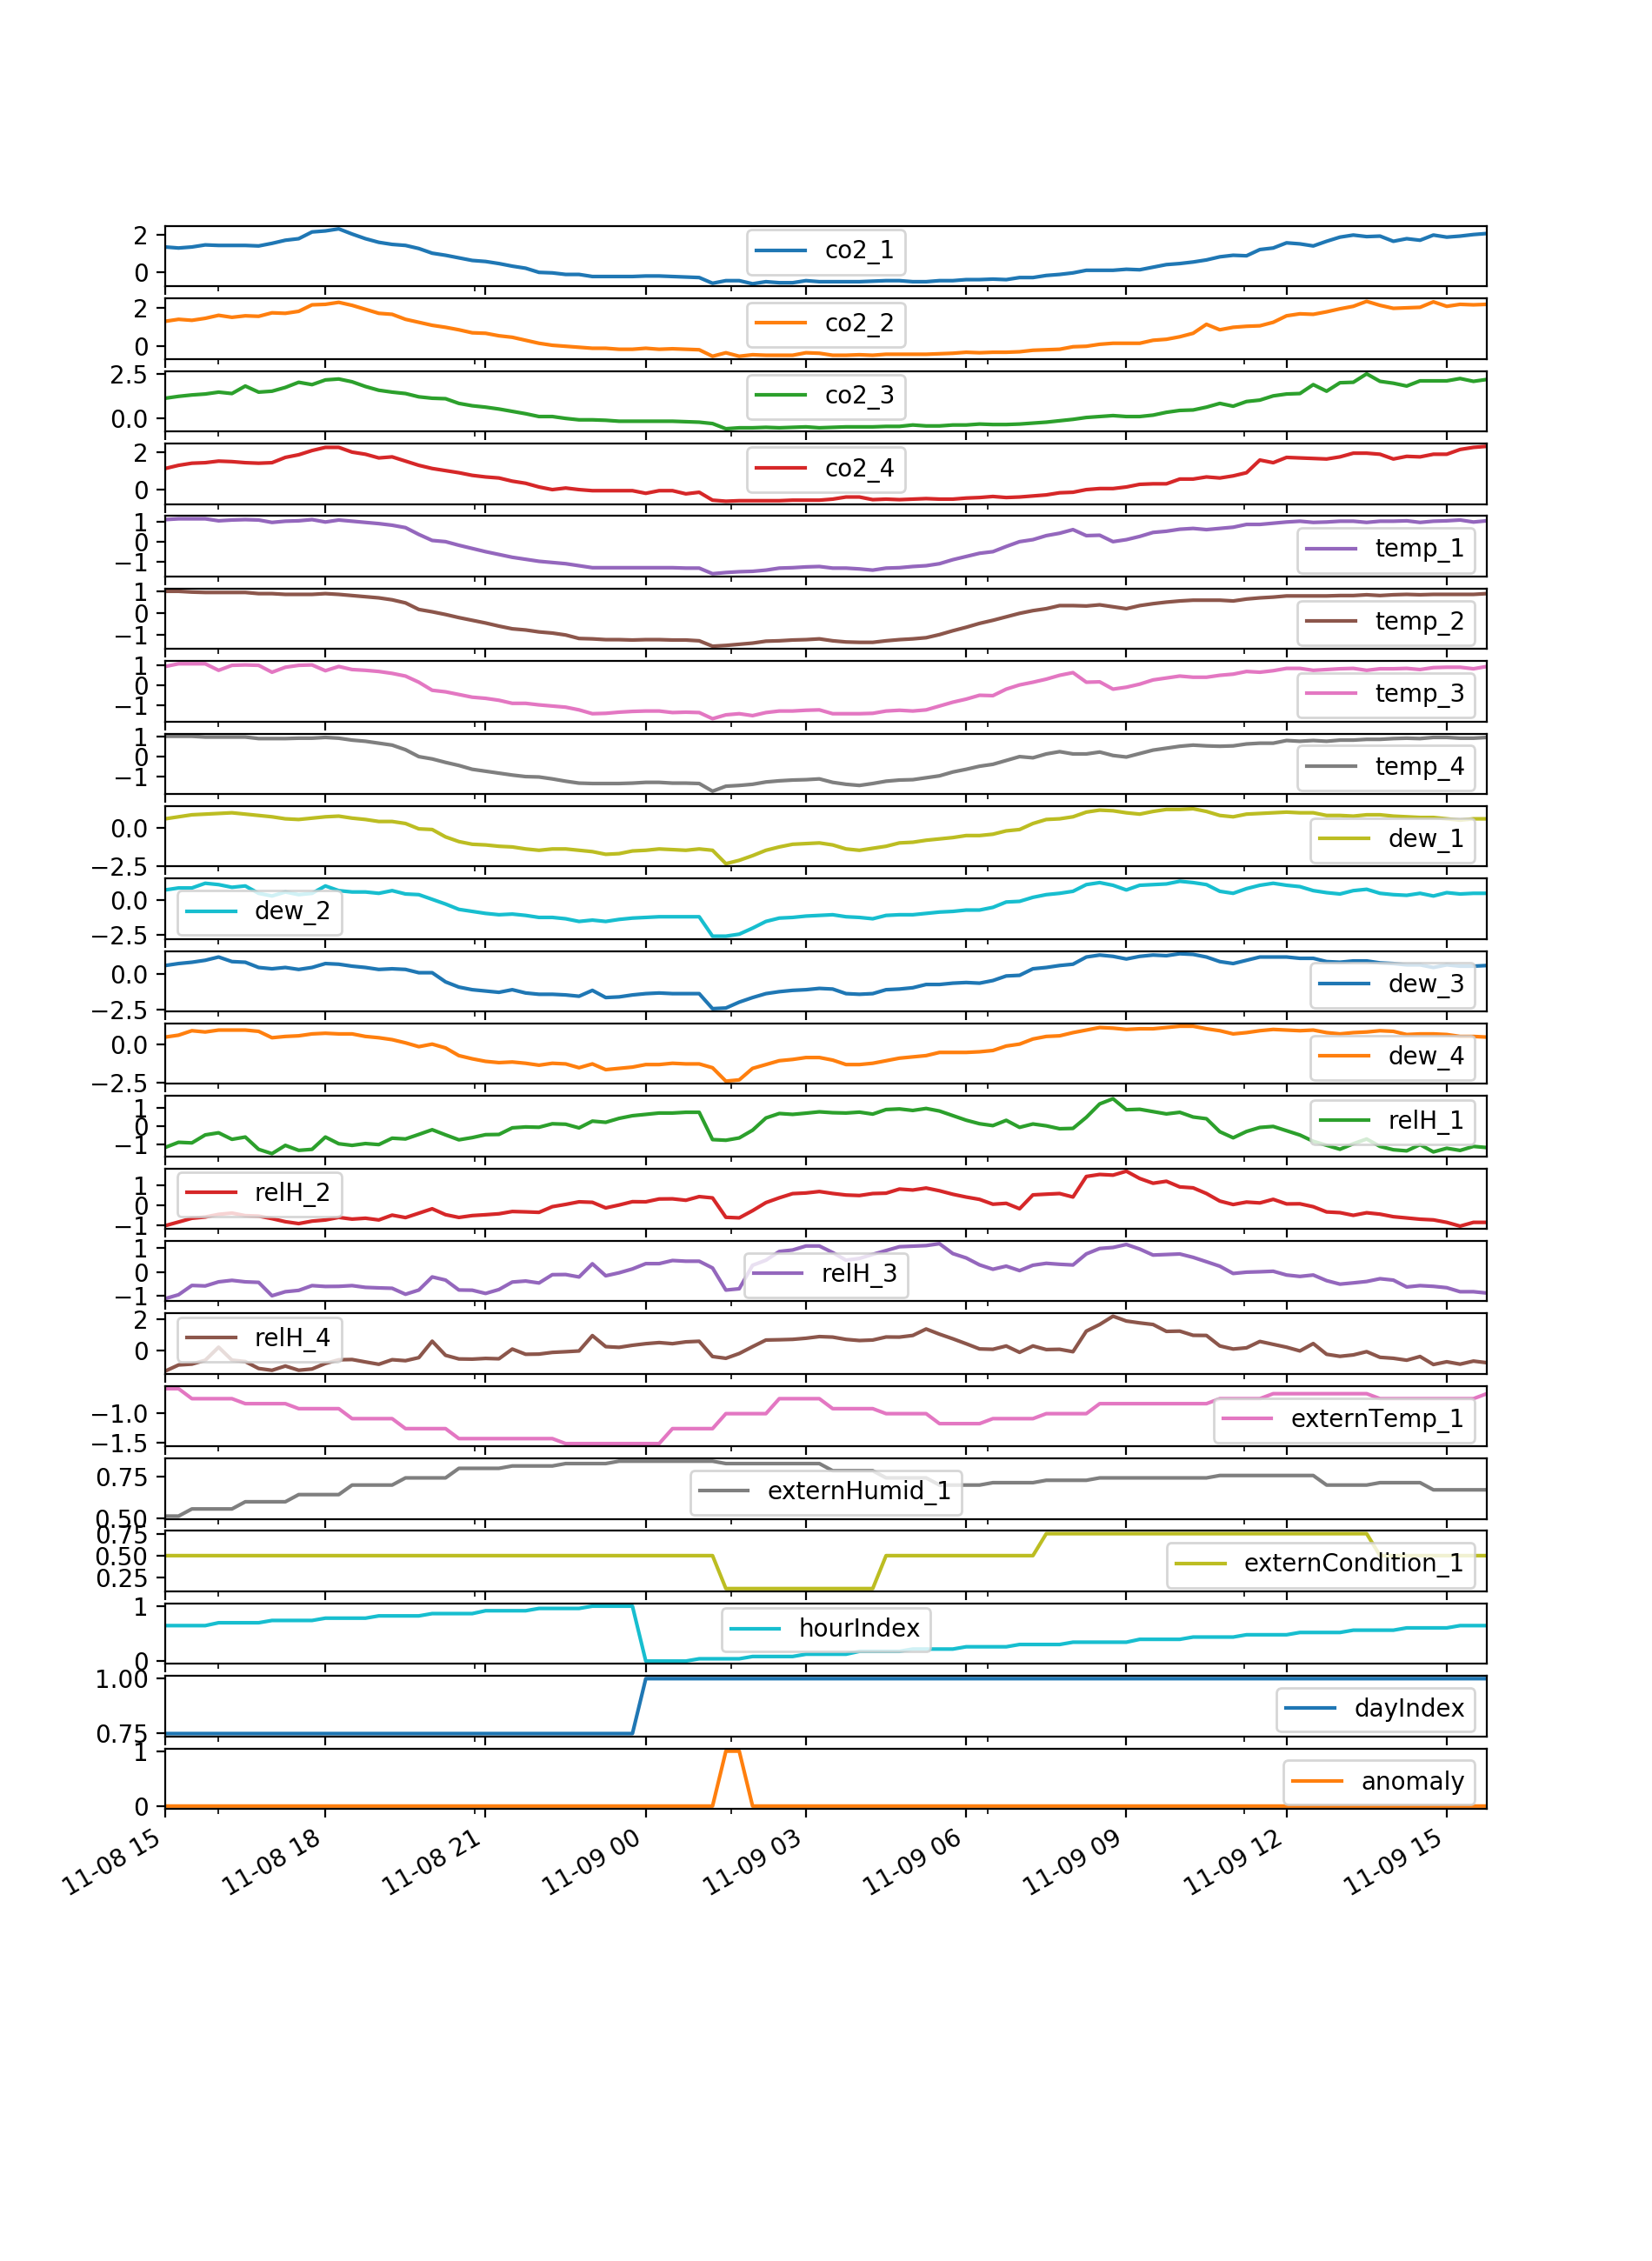

In [196]:
weekdayData_scaled[21450:21550].plot(subplots=True);

In [39]:
!wget https://making.do/geva_anomalies.pickle.npy

--2019-07-12 21:50:48--  https://making.do/geva_anomalies.pickle.npy
Resolving making.do (making.do)... 208.113.184.135
Connecting to making.do (making.do)|208.113.184.135|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25161 (25K)
Saving to: ‘geva_anomalies.pickle.npy’

geva_anomalies.pick 100%[===================>]  24.57K  --.-KB/s    in 0.001s  

2019-07-12 21:50:48 (19.0 MB/s) - ‘geva_anomalies.pickle.npy’ saved [25161/25161]



In [40]:
geva_anomalies = np.load('geva_anomalies.pickle.npy')

In [41]:
geva_anomalies

array([False, False, False, ..., False, False, False])

In [42]:
geva_anomalies.astype(int)

array([0, 0, 0, ..., 0, 0, 0])

In [44]:
np.argwhere(geva_anomalies==1)

array([[  201],
       [  202],
       [  323],
       [  601],
       [  687],
       [  690],
       [  691],
       [  700],
       [  718],
       [  719],
       [  847],
       [  848],
       [  849],
       [  879],
       [  889],
       [  890],
       [  912],
       [  926],
       [  927],
       [  945],
       [  985],
       [  986],
       [ 1098],
       [ 1110],
       [ 1296],
       [ 1468],
       [ 1589],
       [ 1617],
       [ 1618],
       [ 1859],
       [ 1953],
       [ 1954],
       [ 1956],
       [ 1957],
       [ 1964],
       [ 2050],
       [ 2234],
       [ 2351],
       [ 2355],
       [ 2455],
       [ 2480],
       [ 2482],
       [ 2483],
       [ 2484],
       [ 2486],
       [ 2487],
       [ 2523],
       [ 2920],
       [ 2921],
       [ 2928],
       [ 3222],
       [ 3475],
       [ 3604],
       [ 3607],
       [ 3763],
       [ 4464],
       [ 4736],
       [ 4786],
       [ 4936],
       [ 5039],
       [ 5040],
       [ 5239],
       [

In [46]:
whole_year_df['anomaly_geva'] = pd.Series((geva_anomalies.astype(int)), index=whole_year_df.index)

<IPython.core.display.Javascript object>


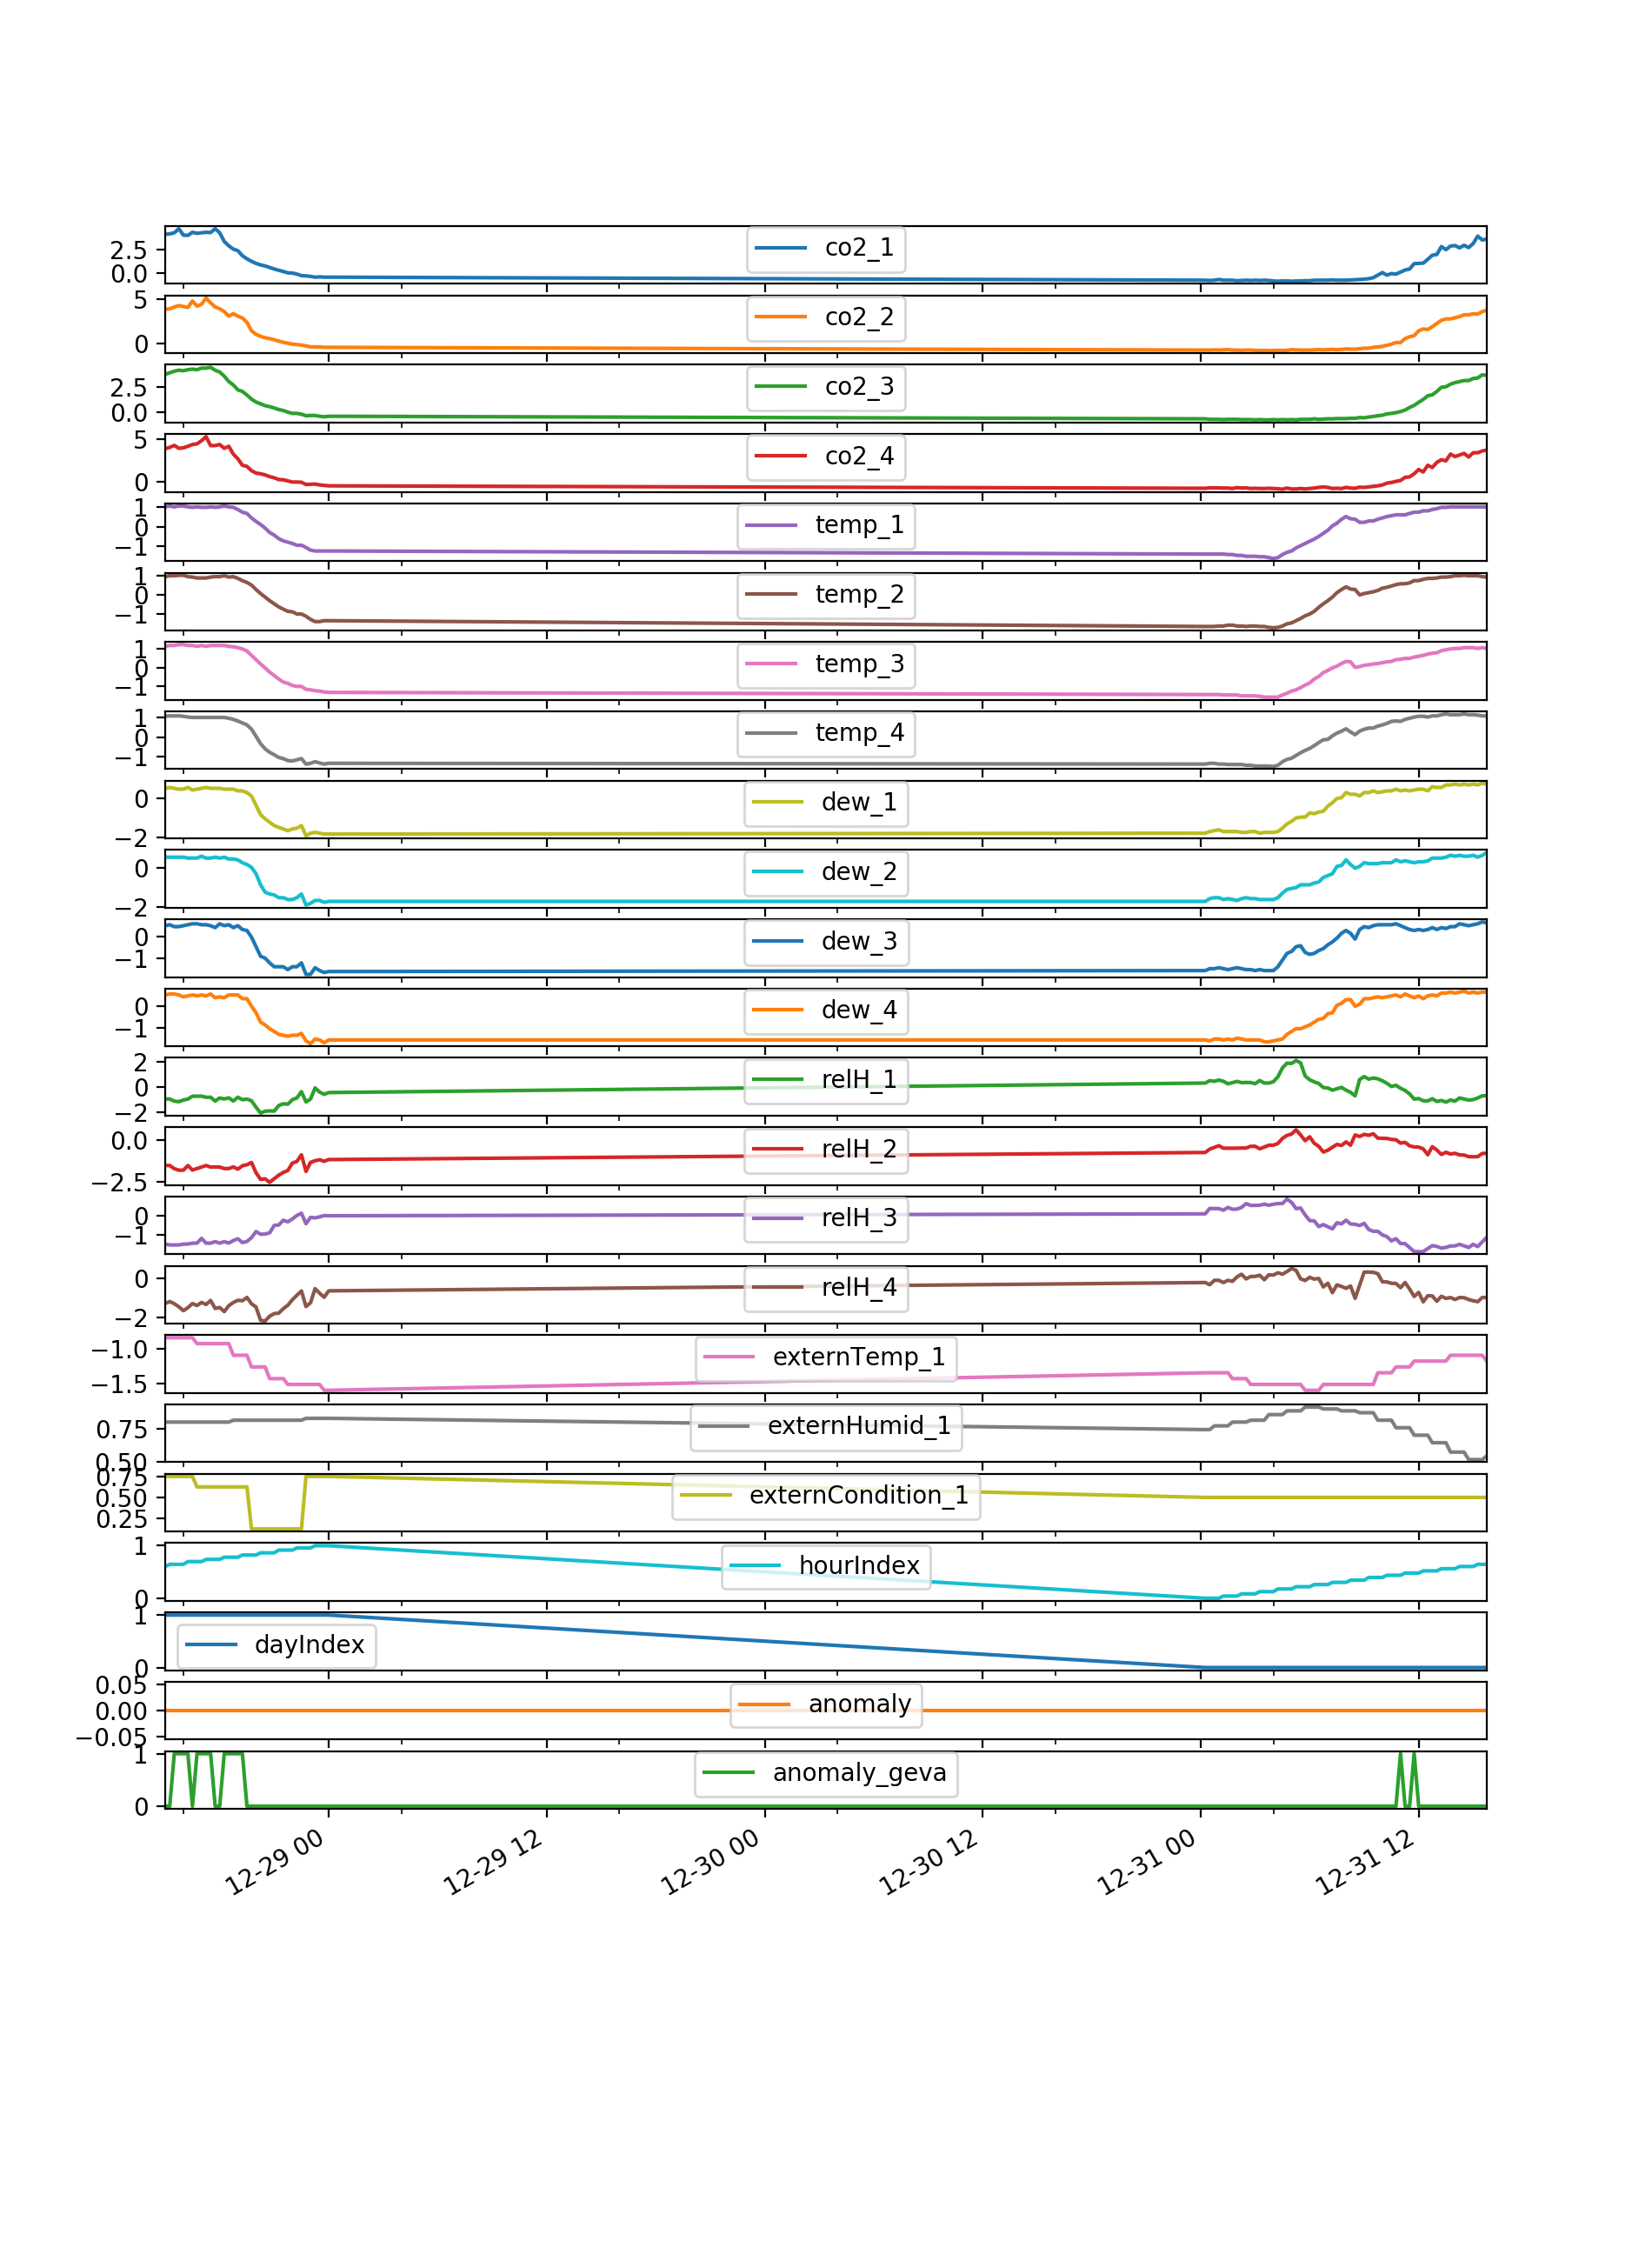

In [67]:
whole_year_df[24900:25000].plot(subplots=True);

In [54]:
!wget https://making.do/geva_error_vector.npy

--2019-07-12 22:09:29--  https://making.do/geva_error_vector.npy
Resolving making.do (making.do)... 208.113.184.135
Connecting to making.do (making.do)|208.113.184.135|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200384 (196K)
Saving to: ‘geva_error_vector.npy’

geva_error_vector.n 100%[===================>] 195.69K  --.-KB/s    in 0.009s  

2019-07-12 22:09:29 (20.2 MB/s) - ‘geva_error_vector.npy’ saved [200384/200384]



In [56]:
!ls -l *h5

-rw-rw-r-- 1 ec2-user ec2-user 41032 Jul 12 21:10 autoencoder_plants.h5


In [57]:
geva_anomalies = np.load('geva_error_vector.npy')

In [61]:
np.argwhere(geva_anomalies>=(geva_anomalies.mean()+10*geva_anomalies.std()))

array([[  718],
       [  719],
       [ 1589],
       [19998],
       [23384],
       [23669],
       [24753],
       [24908]])